<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

**Задача:**

Необходимо построить модель машинного обучения для прогнозирования количества заказов такси на следующий час.

**Данные:**

В распоряжении имеются исторические данные о заказах такси в аэропортах.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_squared_error


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

**Загрузка и подготовка данных**

In [2]:
df_taxi = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

Выведем информацию о данных.

In [3]:
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


По данным видно, что информация с 1 марта 2018 года по 31 августа 2018 года.

И рассмотрим таблицу с данными.

In [4]:
df_taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Для начала проверим, в хронологическом ли порядке расположены даты и время. 

In [5]:
if df_taxi.index.is_monotonic == True:
    print('Дата и время расположенны в хронологическом порядке.')
else:
    print('Дата и время рамположенны не в хронологическом порядке. Необходимо отсортировать индексы.')

Дата и время расположенны в хронологическом порядке.


Далее проведем ресемплирование с длиной интервала в один час.

In [6]:
df_taxi = df_taxi.resample('1H').sum()

**Вывод:**

Данные загруженны и изученны. Подготовленны для анализа и обучения.

## Анализ

Рассмотрим график заказов за весь период.

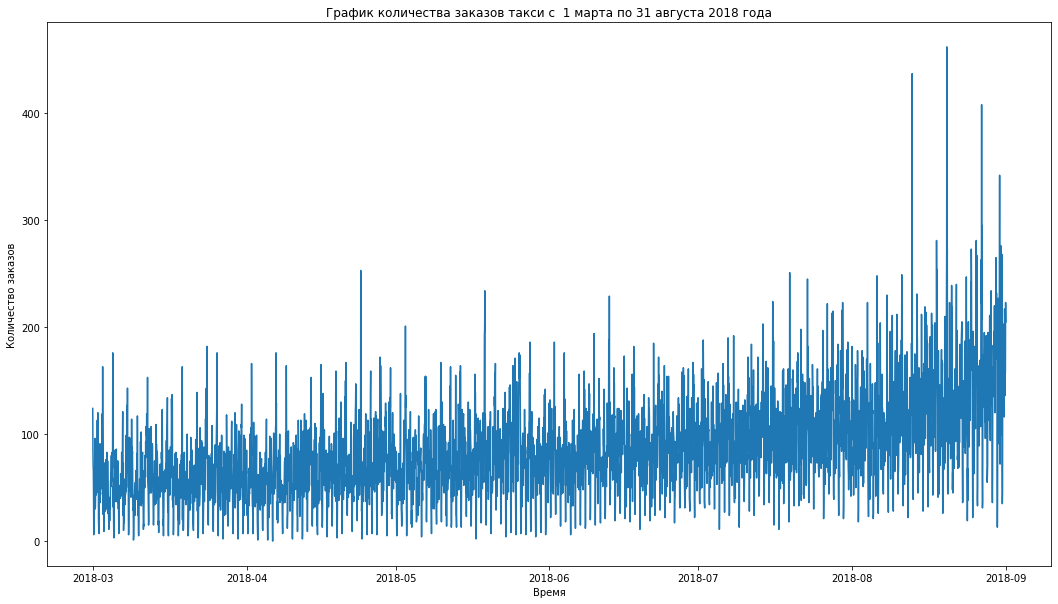

In [7]:
figsize = (18,10)

plt.figure(figsize=figsize)
plt.title('График количества заказов такси с  1 марта по 31 августа 2018 года')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.plot(df_taxi);

Не особо понятно по графику, что происходит. Рассмотрим более меньший период.

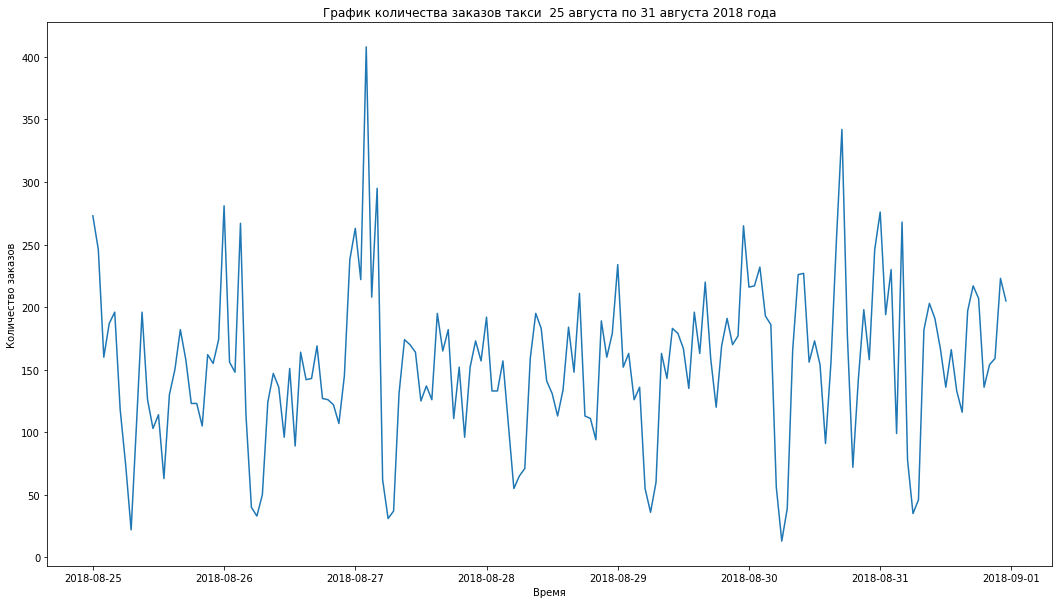

In [8]:
plt.figure(figsize=figsize)
plt.title('График количества заказов такси  25 августа по 31 августа 2018 года')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.plot(df_taxi['2018-08-25':'2018-08-31']);

Рассмотрим тренды, сезонность и  остаток декомпозиции заказов.

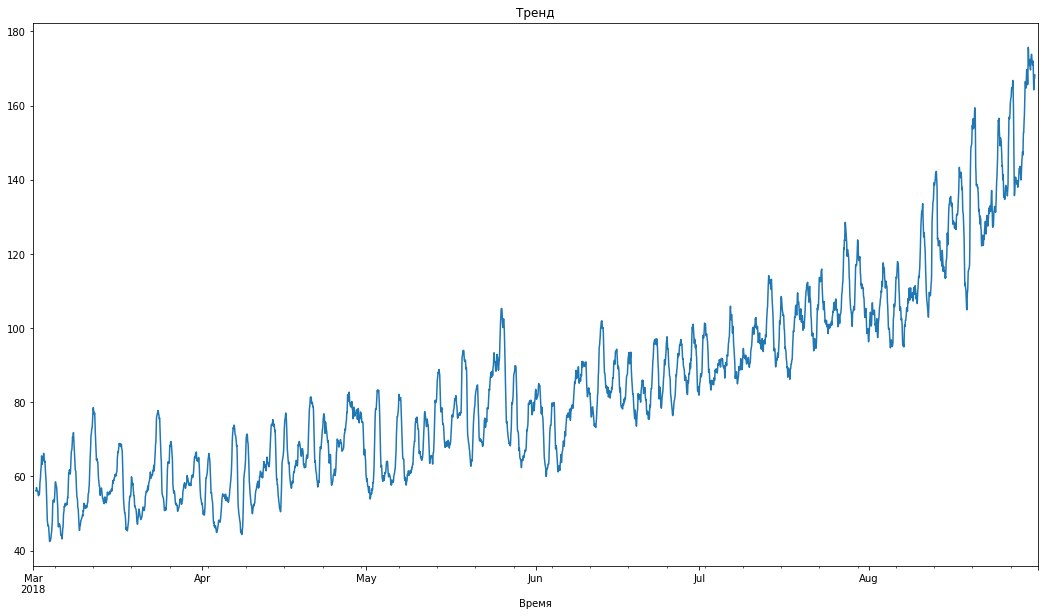

In [9]:
decomposed = seasonal_decompose(df_taxi)
decomposed.trend.plot(figsize=figsize, title='Тренд', xlabel='Время');

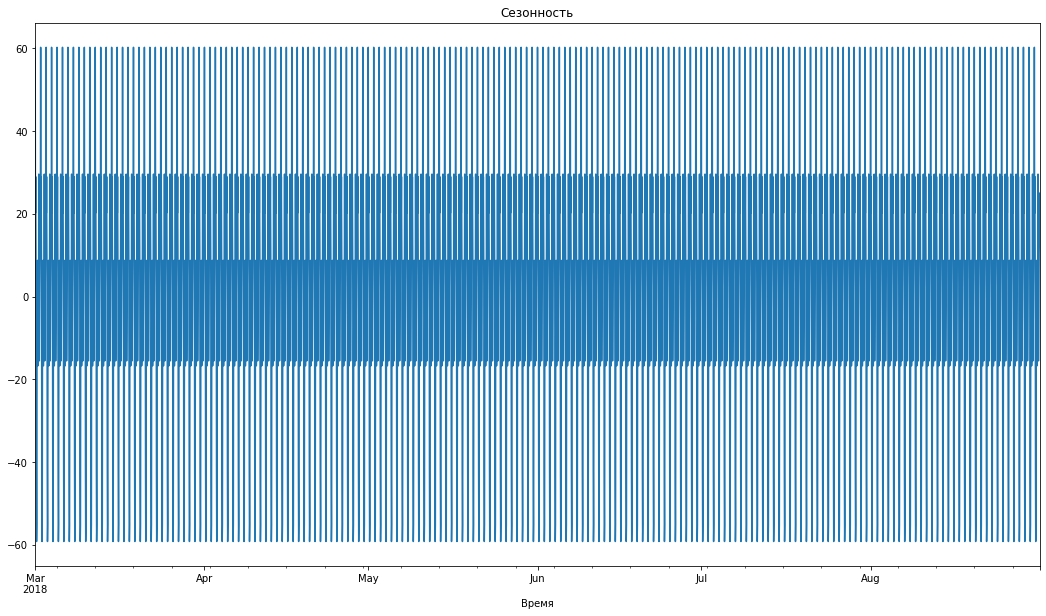

In [10]:
decomposed.seasonal.plot(figsize=figsize, title='Сезонность', xlabel='Время');

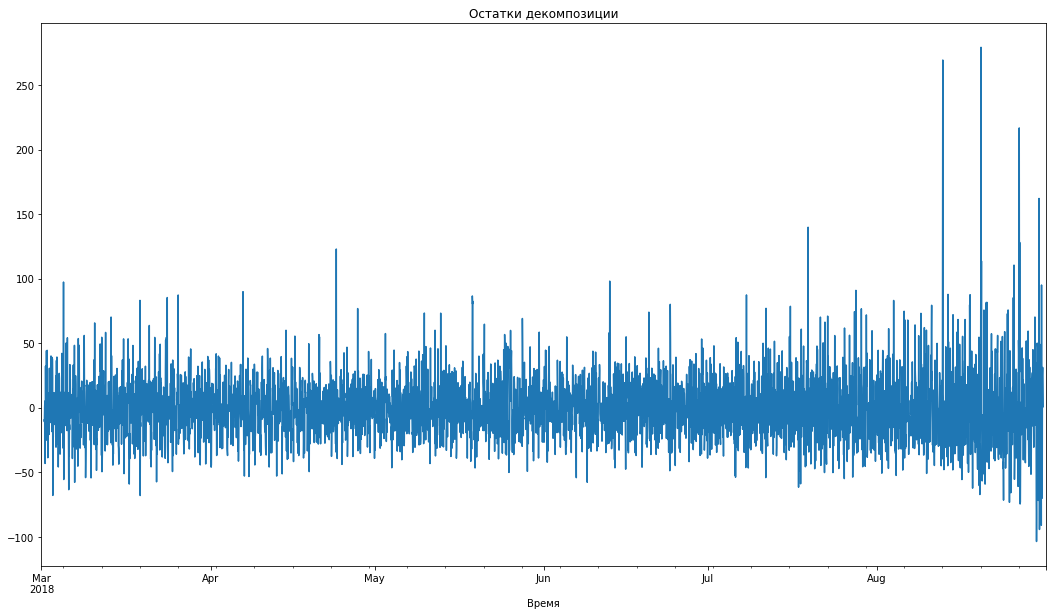

In [11]:
decomposed.resid.plot(figsize=figsize, title='Остатки декомпозиции', xlabel='Время');

Так же рассмотрим более меньший период.

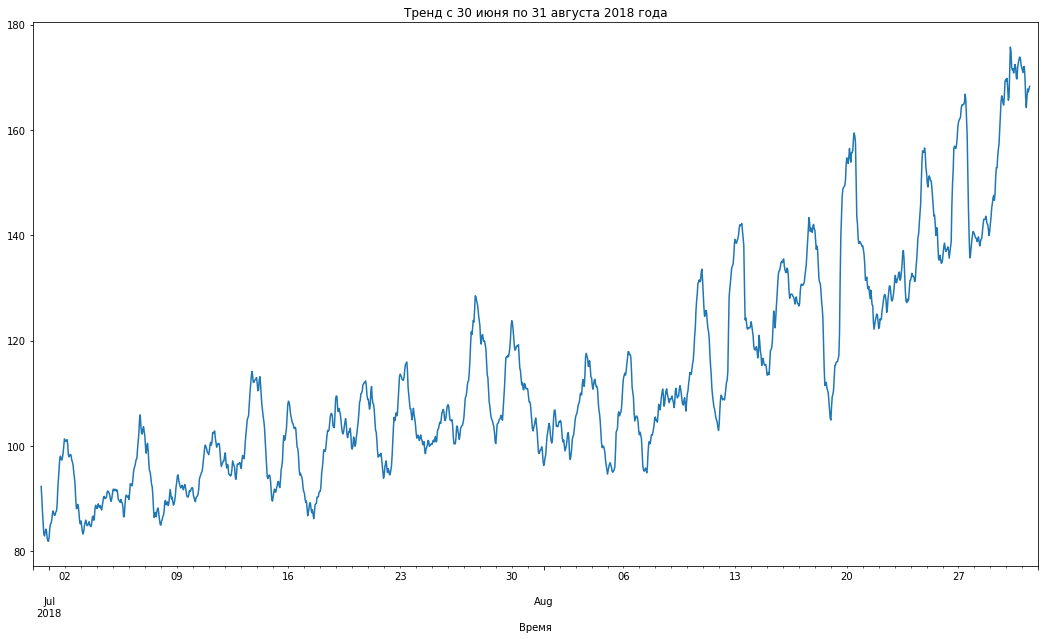

In [12]:
decomposed = seasonal_decompose(df_taxi['2018-06-30':'2018-08-31'])
decomposed.trend.plot(figsize=figsize, title='Тренд с 30 июня по 31 августа 2018 года', xlabel='Время');

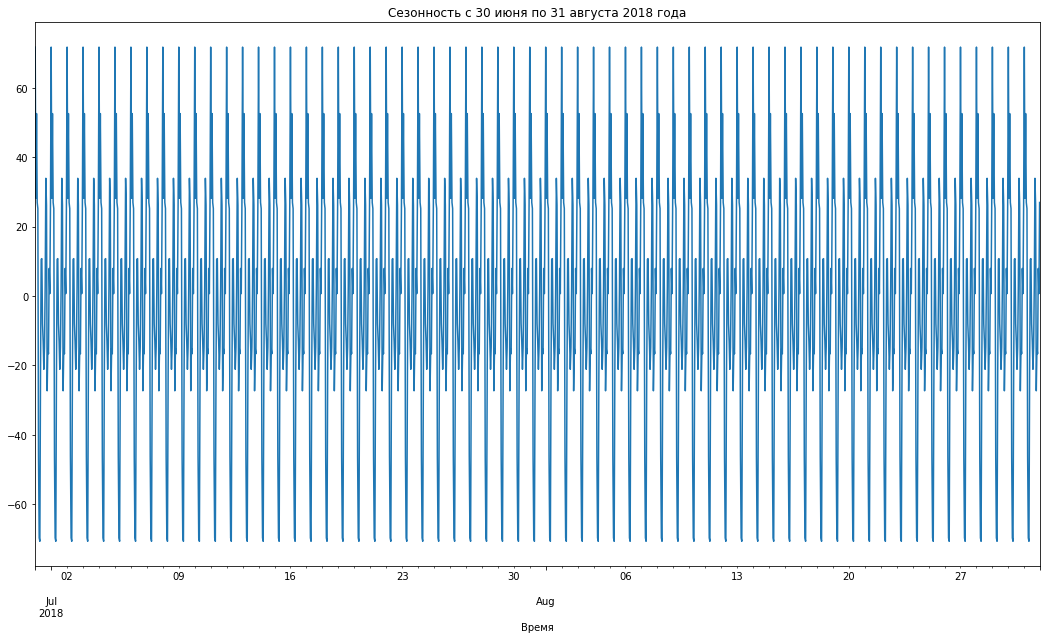

In [13]:
decomposed.seasonal.plot(figsize=figsize, title='Сезонность с 30 июня по 31 августа 2018 года', xlabel='Время');

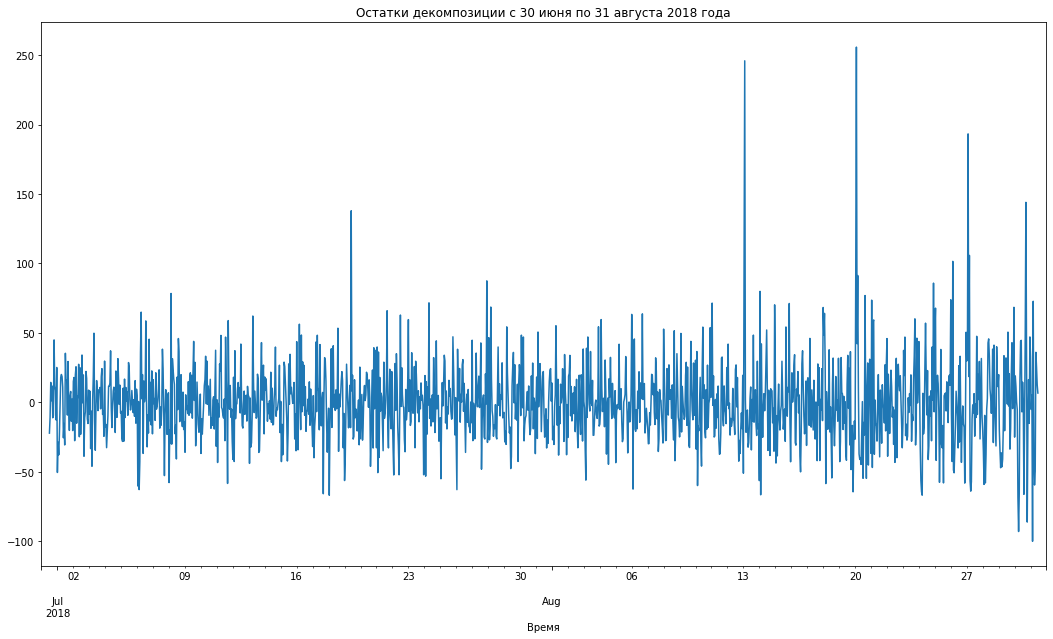

In [14]:
decomposed.resid.plot(figsize=figsize, title='Остатки декомпозиции с 30 июня по 31 августа 2018 года', xlabel='Время');

Так же рассмотрим стационарные временные ряды.

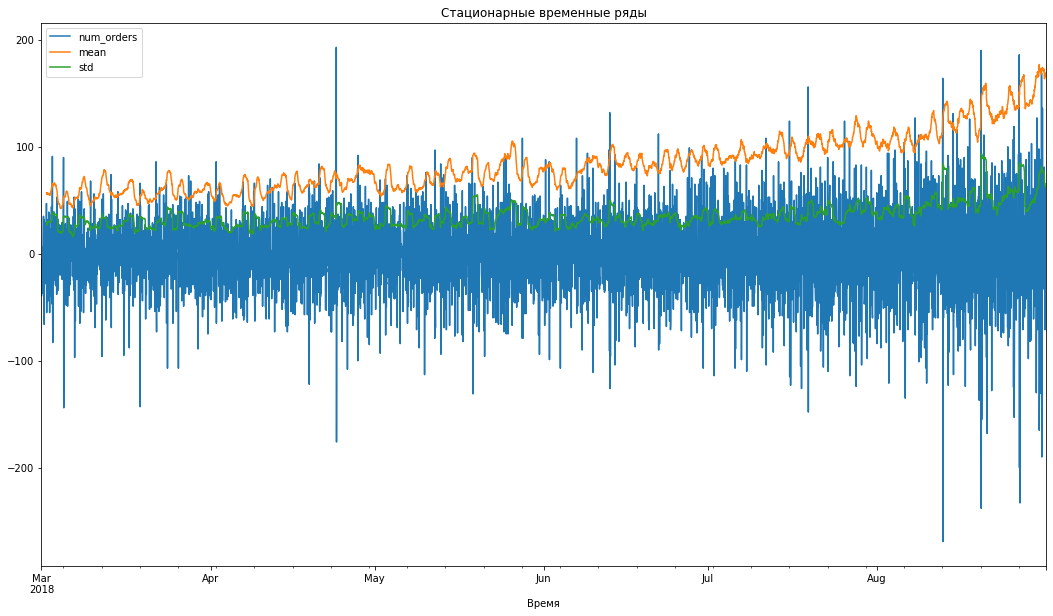

In [15]:
df_shift = df_taxi - df_taxi.shift()
df_shift['mean'] = df_taxi['num_orders'].rolling(24).mean()
df_shift['std'] = df_taxi['num_orders'].rolling(24).std()
df_shift.plot(figsize=figsize, title='Стационарные временные ряды', xlabel='Время');

In [16]:
ts = df_taxi['num_orders']
st_test = adfuller(ts, regression='ctt')

if st_test[1] < 0.05:
    print('Ряд стационарный')
else:
    print('Ряд нестационарный')

Ряд стационарный


**Вывод:**

- Дисперсия ряда со временем увеличивается.
- Тренд в общем растет, то есть количество заказов и пользователей растет;
- Видно что в раннее утро количество заказов резко падает;
- Временной ряд в не является стационарным, так как подвержен тренду, который меняется во времени, но по тесту Дики-Фуллера ряд считается стационарным.

Исследуем и создадим новые признаки для обучения. 

Так как видна ежедневная сезонность - необходим признак day.

Тренд показывает, что к концу недели и в середине идет увеличение заказов - добавим признак dayofweek.

Для определения горизонта прогназирования (`lag`) возьмем значение в 24 часа.

Для определения ширины окна скользящего среднего (`rolling_mean`) возьмем значение в 48 часов.

In [17]:
def make_features(data, column, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[column].shift(lag)

    data['rolling_mean'] = data[column].shift().rolling(rolling_mean_size).mean()

In [18]:
make_features(df_taxi, 'num_orders', 24, 48)

In [19]:
train, test = train_test_split(df_taxi, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

Размеры выборок.

In [20]:
print(features_train.shape)
print(target_train.shape)

(3926, 27)
(3926,)


In [21]:
print(features_test.shape)
print(target_test.shape)

(442, 27)
(442,)


**Вывод:**

Данные проанализированны и готовы признаки для обучения. Можно приступать к самому обучению моделей машинного обучения.

## Обучение

Обучение проведем для слeдующих моделей:
- LinearRegression;
- LGBMRegressor;
- CatBoostRegressor;
- DecisionTreeRegressor;
- RandomForestRegressor.

**Линейная регрессия**

In [22]:
cv = TimeSeriesSplit(n_splits=3).split(features_train)
model_lr = LinearRegression() 
model_lr.fit(features_train, target_train)
score_lr = cross_val_score(model_lr, features_train, target_train, scoring='neg_mean_squared_error', cv=cv)
lr_rmse = np.mean(-score_lr)**0.5
print(f'Best RMSE: {lr_rmse:.2f}')

Best RMSE: 28.56


**Модель LightGBM**

In [23]:
regressor = LGBMRegressor() 
hyperparams = [{'learning_rate':[x/10 for x in range(1, 6)],
                'max_depth': [1,5,10,15],
                'random_state':[123435]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)
print(clf.best_params_)
lgbm_rmse = (max(clf.cv_results_["mean_test_score"])*-1) ** 0.5
print(f'Best RMSE: {lgbm_rmse:.3f}')

{'learning_rate': 0.1, 'max_depth': 10, 'random_state': 123435}
Best RMSE: 24.782


**Модель CatBoost**

In [24]:
regressor = CatBoostRegressor() 
hyperparams = [{'depth':[1,2,3,4,5],
                'learning_rate':[0.1, 0.2, 0.3],
                'iterations':[1,50,150],
                'random_state':[123435],
                'verbose':[False]}]


clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)
print(clf.best_params_)
cat_rmse = (max(clf.cv_results_["mean_test_score"])*-1) ** 0.5
print(f'Best RMSE: {cat_rmse:.3f}')

{'depth': 5, 'iterations': 150, 'learning_rate': 0.2, 'random_state': 123435, 'verbose': False}
Best RMSE: 24.511


**Дерево решений**

In [25]:
regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(2, 15)]
hyperparams = [{'criterion':['mse'], 
                'max_depth':max_depth_list, 
                'random_state':[12345]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)
print(clf.best_params_)
dtr_rmse = (max(clf.cv_results_["mean_test_score"])*-1) ** 0.5
print(f'Best RMSE: {dtr_rmse:.3f}')

{'criterion': 'mse', 'max_depth': 6, 'random_state': 12345}
Best RMSE: 29.419


**Случайный лес**

In [26]:
regressor = RandomForestRegressor() 
n_estimators_list = [x for x in range(50,110,10)]
hyperparams = [{'criterion':['mse'], 
                'n_estimators':n_estimators_list,
                'max_depth':max_depth_list, 
                'random_state':[12345]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)
print(clf.best_params_)
rfr_rmse = (max(clf.cv_results_["mean_test_score"])*-1) ** 0.5
print(f'Best RMSE: {rfr_rmse:.3f}')

{'criterion': 'mse', 'max_depth': 14, 'n_estimators': 90, 'random_state': 12345}
Best RMSE: 25.083


## Тестирование

На основе результатов передсказаний возьмем следующие модели:

- LGBMRegressor;
- CatBoostRegressor;
- RandomForestRegressor.

Проверим на константной модели адекватность тестовых данных.

In [27]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]
pred_RMSE=round(mean_squared_error(target_test, pred_previous), 1) ** 0.5
print('RMSE для проверки модели на адекватность:',pred_RMSE )

RMSE для проверки модели на адекватность: 58.856605406700105


Протестируем модели на тестовых данных.

**Модель LightGBM**

In [28]:
lgbm_test = LGBMRegressor(learning_rate=0.1, max_depth=10, random_state = 12345) 
lgbm_test.fit(features_train, target_train)
predict_lgbm_test = lgbm_test.predict(features_test)
lgbm_rmse_test = mean_squared_error(target_test, predict_lgbm_test) ** 0.5
print(f'best RMSE: {lgbm_rmse_test:.3f}')

best RMSE: 43.251


**Модель CatBoost**

In [29]:
cat_test = CatBoostRegressor(depth=5, iterations=150, learning_rate=0.2,
                             random_state=12345, verbose=False)
cat_test.fit(features_train, target_train)
predict_cat_test = cat_test.predict(features_test)
cat_rmse_test = mean_squared_error(target_test, predict_cat_test) ** 0.5
print(f'best RMSE: {cat_rmse_test:.3f}')

best RMSE: 41.584


**Случайный лес**

In [30]:
rfr_test = RandomForestRegressor(criterion='mse', max_depth=14,
                                 n_estimators=90, random_state=12345)
rfr_test.fit(features_train, target_train)
predict_rfr_test = rfr_test.predict(features_test)
rfr_rmse_test = mean_squared_error(target_test, predict_rfr_test) ** 0.5
print(f'best RMSE: {rfr_rmse_test:.3f}')

best RMSE: 44.436


**Таблица результатов моделей для сравнения** 

In [31]:
table = pd.DataFrame(index=['LinearRegression',
                            'LGBMRegressor',
                            'CatBoostRegressor',
                            'DecisionTreeRegressor',
                            'RandomForestRegressor'],
                     columns=['RMSE при обучении', 'RMSE на тестовых данных'])

table['RMSE при обучении'] = f'{lr_rmse:.2f}', f'{lgbm_rmse:.2f}', f'{cat_rmse:.2f}', f'{dtr_rmse:.2f}', f'{rfr_rmse:.2f}' 
table['RMSE на тестовых данных'] = '-',f'{lgbm_rmse_test:.2f}', f'{cat_rmse_test:.2f}', '-', f'{rfr_rmse_test:.2f}'
table

,RMSE при обучении,RMSE на тестовых данных
LinearRegression,28.56,-
LGBMRegressor,24.78,43.25
CatBoostRegressor,24.51,41.58
DecisionTreeRegressor,29.42,-
RandomForestRegressor,25.08,44.44


**Вывод:**

По итогам тестирования лучшей моделью для прогноза количества заказов такси на следующий час является модель CatBoost.

## Вывод 

Была построенна модель для прогноза количества заказов такси на следующий час.

В распоряжении были исторические данные о заказах такси в аэропортах, а именно с 1 марта по 31 августа 2018 года. Данные содержали в себе время и количество заказов с периодичностью в 10 минут.

В начале были изученны данные и проведенно ресемплирование по одному часу.

Далее были проанализированны данные. Рассмотренны: график самих данных, график тренда, график сезонности, график остатока декомпозиции и график стационарных временных рядов. На основе анализа созданы новые признаки для обучения.

После были обучены и подобранны гиперпараметры следующим моделям:
- LinearRegression;
- LGBMRegressor;
- CatBoostRegressor;
- DecisionTreeRegressor;
- RandomForestRegressor.

После обучение, все модели были протестированы, метрика RMSE для моделей была сравнена с метрикой по константной модели. Для заказчика было важно, чтобы значение метрики RMSE на тестовой выборке было не больше 48. Все модели кроме модели дерева решений прошли этот порог. И в конечном счете, лучшей моделью показала себя модель **CatBoost** со значением метрики RMSE в **41.58** на тестовой выборке.